In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import nnx_module
from numpyro.handlers import block, do, seed, trace
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from pydantic import BaseModel

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
class DataGenerationParameters(BaseModel):
    num_train: int
    num_test: int
    feature_dim: int
    z_gap: float
    y_gap: float


data_generation_parameters = DataGenerationParameters(
    num_train=10_000,
    num_test=2_000,
    feature_dim=10,
    z_gap=1.0,
    y_gap=3.0,
)

In [3]:
def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[
    Float[Array, "num_data feature_dim"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
]:
    # Latent confounder z is binary.
    with numpyro.plate("num_data", num_data):
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        # Covariates x are normally distributed, with higher variance for z=1.
        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z))).T

        # Treatment t is binary, with higher probability for z=1.
        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))

        # Outcome y is binary, with higher probability for z=1 and t=1.
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        # Compute true c-specific CATE for evaluation.
        t0_t1 = jnp.array([[0.0], [1.0]])
        y_t0_t1 = numpyro.sample(
            "y_t0_t1", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1)))
        )

        y_t0 = y_t0_t1[0]
        y_t1 = y_t0_t1[1]

        true_cates = y_t1 - y_t0

        return (x, t, y, z, true_cates)

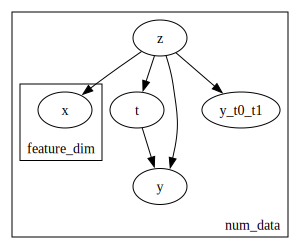

In [4]:
numpyro.render_model(
    generate_data,
    model_kwargs={
        "num_data": data_generation_parameters.num_train,
        "feature_dim": data_generation_parameters.feature_dim,
        "z_gap": data_generation_parameters.z_gap,
        "y_gap": data_generation_parameters.y_gap,
    },
)

In [5]:
x_train: Float[Array, "num_train feature_dim"]
t_train: Int[Array, " num_train"]
y_train: Int[Array, " num_train"]

rng_key, rng_subkey = random.split(rng_key)

x_train, t_train, y_train, _, _ = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_train,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)


x_test: Float[Array, "feature_dim num_test"]
z_test: Int[Array, " num_test"]
true_cates: Float[Array, " num_test"]

x_test, _, _, z_test, true_cates = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_test,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)

In [6]:
class FullyConnected(nnx.Module):
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])

        layer_dims = [din, *hidden_layers, dout]

        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: Array) -> Array:
        for layer in self.layers:
            x = jax.nn.elu(layer(x))
        return x


class DiagNormalNet(FullyConnected):
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        super().__init__(din=din, dout=2 * dout, hidden_layers=hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        loc, scale = jnp.split(super().__call__(x), 2, axis=-1)
        return loc, jax.nn.softplus(scale)


class BernoulliNet(FullyConnected):
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        super().__init__(din, dout, hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> Array:
        return jax.lax.clamp(min=-10.0, max=10.0, x=super().__call__(x))

In [7]:
class ModelParameters(BaseModel):
    feature_dim: int
    hidden_dim: int
    latent_dim: int
    num_layers: int


model_parameters = ModelParameters(
    feature_dim=x_train.shape[1],
    latent_dim=5,
    hidden_dim=200,
    num_layers=3,
)

In [8]:
rng_key, rng_subkey = random.split(rng_key)
x_nn_module = DiagNormalNet(
    din=model_parameters.latent_dim,
    dout=model_parameters.feature_dim,
    hidden_layers=[model_parameters.hidden_dim] * model_parameters.num_layers,
    rngs=nnx.Rngs(rng_subkey),
)

rng_key, rng_subkey = random.split(rng_key)
t_nn_module = BernoulliNet(
    din=model_parameters.latent_dim,
    dout=1,
    hidden_layers=[1],
    rngs=nnx.Rngs(rng_subkey),
)

rng_key, rng_subkey = random.split(rng_key)
y_nn_0_module = BernoulliNet(
    din=model_parameters.latent_dim,
    dout=1,
    hidden_layers=[model_parameters.hidden_dim] * model_parameters.num_layers,
    rngs=nnx.Rngs(rng_subkey),
)

rng_key, rng_subkey = random.split(rng_key)
y_nn_1_module = BernoulliNet(
    din=model_parameters.latent_dim,
    dout=1,
    hidden_layers=[model_parameters.hidden_dim] * model_parameters.num_layers,
    rngs=nnx.Rngs(rng_subkey),
)

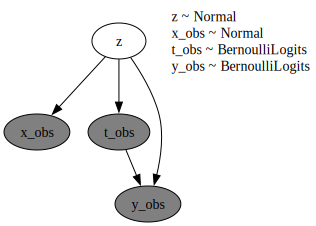

In [9]:
def model(
    x: Float[Array, "num_data feature_dim"],
    t: Int[Array, " num_data"],
    y: Int[Array, " num_data"] | None = None,
    latent_dim: int = 1,
) -> None:
    num_data, n_features = x.shape

    z = numpyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))

    x_nn = nnx_module("x_nn", x_nn_module)
    x_nn_z = x_nn(z)

    x_loc = x_nn_z[0][None, :]
    x_scale = x_nn_z[1][None, :]

    numpyro.sample(
        "x_obs",
        dist.Normal(x_loc, x_scale).expand([num_data, n_features]).to_event(2),
        obs=x,
    )

    t_nn = nnx_module("t_nn", t_nn_module)
    t_nn_z = t_nn(z)

    t_obs = numpyro.sample(
        "t_obs",
        dist.Bernoulli(logits=t_nn_z).expand([num_data]),
        obs=t,
    )

    y_nn_0 = nnx_module("y_nn_0", y_nn_0_module)
    y_nn_0_z = y_nn_0(z)

    y_nn_1 = nnx_module("y_nn_1", y_nn_1_module)
    y_nn_1_z = y_nn_1(z)

    y_logits = jnp.where(t_obs == 1, y_nn_1_z, y_nn_0_z)

    numpyro.sample(
        "y_obs",
        dist.Bernoulli(logits=y_logits).expand([num_data]),
        obs=y,
    )


numpyro.render_model(
    model,
    model_kwargs={
        "x": x_train,
        "t": t_train,
        "y": y_train,
        "latent_dim": model_parameters.latent_dim,
    },
    render_distributions=True,
)

100%|██████████| 10000/10000 [00:05<00:00, 1830.87it/s, init loss: 1987349.0000, avg. loss [9501-10000]: 292292.0000]


CPU times: user 14.6 s, sys: 6.11 s, total: 20.7 s
Wall time: 7.99 s


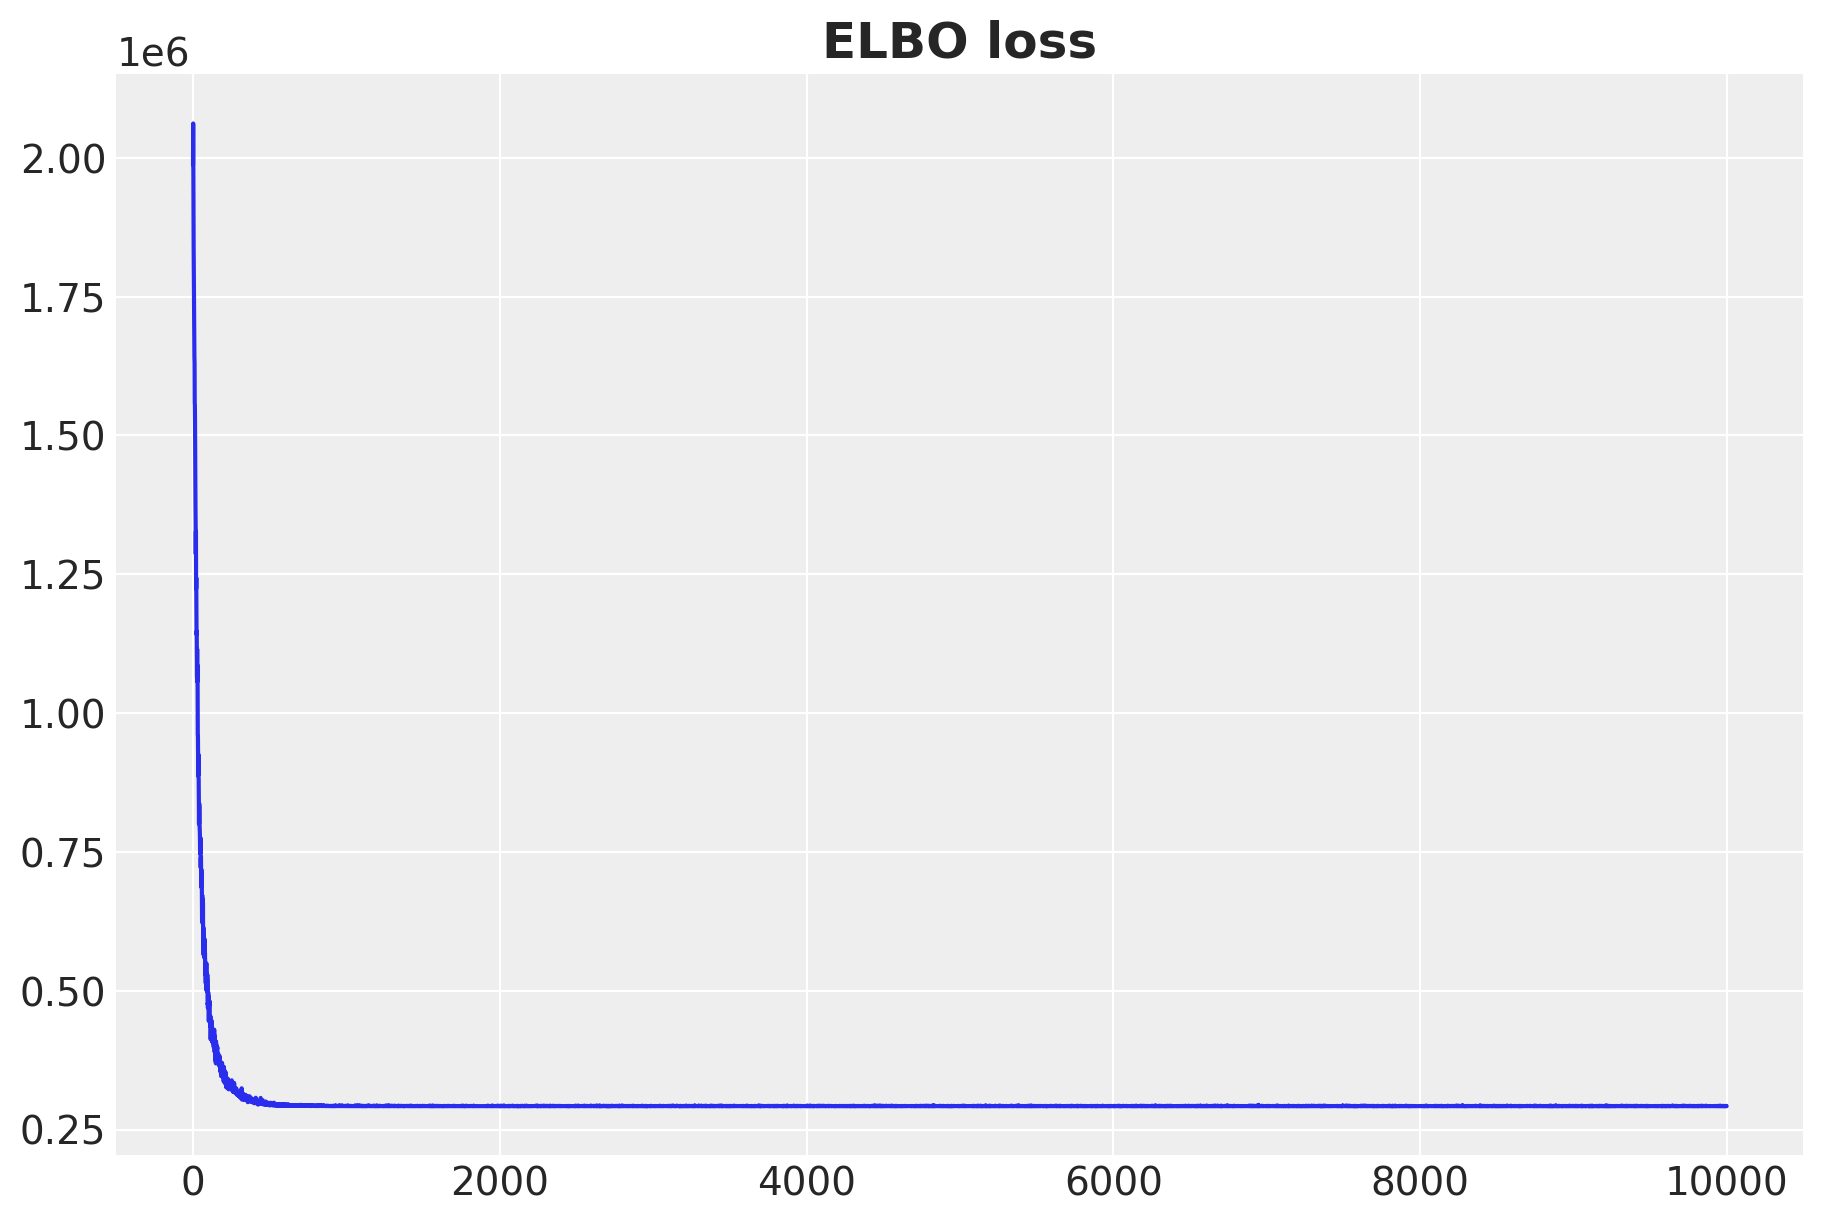

In [10]:
%%time
guide = AutoNormal(model)

scheduler = optax.linear_onecycle_schedule(
    transition_steps=10_000,
    peak_value=0.0001,
    pct_start=0.2,
    pct_final=0.8,
    div_factor=3,
    final_div_factor=4,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.1,
        patience=10,
        accumulation_size=100,
    ),
)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 10_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    x=x_train,
    t=t_train,
    y=y_train,
    latent_dim=model_parameters.latent_dim,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [11]:
params = svi_result.params

train_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
)

# Generate samples for training data
rng_key, rng_subkey = random.split(key=rng_key)
train_posterior_predictive_samples = train_posterior_predictive(
    rng_subkey, x=x_train, t=t_train, latent_dim=model_parameters.latent_dim
)

# Convert to ArviZ InferenceData for analysis and visualization
train_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in train_posterior_predictive_samples.items()
    },
    coords={
        "feature": np.arange(x_train.shape[1]),
        "obs_idx": np.arange(x_train.shape[0]),
    },
    dims={
        "x_obs": ["obs_idx", "feature"],
        "t_obs": ["obs_idx"],
        "y_probs": ["obs_idx"],
        "y_obs": ["obs_idx"],
    },
)

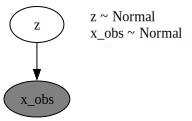

In [12]:
numpyro.render_model(
    block(model, hide=["t_obs", "y_obs"]),
    model_kwargs={
        "x": x_train,
        "t": t_train,
        "latent_dim": model_parameters.latent_dim,
    },
    render_distributions=True,
)

In [13]:
do_0_model = do(model, {"t_obs": jnp.zeros(x_train.shape[0], dtype=jnp.int32)})
do_1_model = do(model, {"t_obs": jnp.ones(x_train.shape[0], dtype=jnp.int32)})

rng_key, rng_subkey = random.split(rng_key)
train_do_0_model_samples = Predictive(
    do_0_model, guide=guide, params=params, num_samples=2_000, return_sites=["y_obs"]
)(
    rng_subkey,
    x=x_train,
    t=t_train,
    latent_dim=model_parameters.latent_dim,
)

rng_key, rng_subkey = random.split(rng_key)
train_do_1_model_samples = Predictive(
    do_1_model, guide=guide, params=params, num_samples=2_000, return_sites=["y_obs"]
)(
    rng_subkey,
    x=x_train,
    t=t_train,
    latent_dim=model_parameters.latent_dim,
)


train_do_0_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in train_do_0_model_samples.items()
    },
    coords={"obs_idx": np.arange(x_train.shape[0])},
    dims={"y_probs": ["obs_idx"]},
)

train_do_1_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in train_do_1_model_samples.items()
    },
    coords={"obs_idx": np.arange(x_train.shape[0])},
    dims={"y_probs": ["obs_idx"]},
)

In [14]:
(
    train_do_1_idata["posterior_predictive"]["y_obs"]
    - train_do_0_idata["posterior_predictive"]["y_obs"]
).mean()

<xarray.DataArray 'y_obs' ()> Size: 8B
array(0.73028155)

In [15]:
do_0_model = do(model, {"t_obs": jnp.zeros(x_test.shape[0], dtype=jnp.int32)})
do_1_model = do(model, {"t_obs": jnp.ones(x_test.shape[0], dtype=jnp.int32)})

rng_key, rng_subkey = random.split(rng_key)
test_do_0_model_samples = Predictive(
    do_0_model, guide=guide, params=params, num_samples=2_000, return_sites=["y_obs"]
)(
    rng_subkey,
    x=x_test,
    t=jnp.empty(shape=x_test.shape[0], dtype=jnp.int32),
    latent_dim=model_parameters.latent_dim,
)

rng_key, rng_subkey = random.split(rng_key)
test_do_1_model_samples = Predictive(
    do_1_model, guide=guide, params=params, num_samples=2_000, return_sites=["y_obs"]
)(
    rng_subkey,
    x=x_test,
    t=jnp.ones(shape=x_test.shape[0], dtype=jnp.int32),
    latent_dim=model_parameters.latent_dim,
)


test_do_0_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_do_0_model_samples.items()
    },
    coords={"obs_idx": np.arange(x_test.shape[0])},
    dims={"y_obs": ["obs_idx"]},
)

test_do_1_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_do_1_model_samples.items()
    },
    coords={"obs_idx": np.arange(x_test.shape[0])},
    dims={"y_obs": ["obs_idx"]},
)

In [16]:
est_cates = (
    (
        test_do_1_idata["posterior_predictive"]["y_obs"]
        - test_do_0_idata["posterior_predictive"]["y_obs"]
    )
    .mean(dim=["chain", "draw"])
    .to_numpy()
)

In [17]:
est_cates_z0, true_cates_z0 = est_cates[z_test == 0], true_cates[z_test == 0]
est_cates_z1, true_cates_z1 = est_cates[z_test == 1], true_cates[z_test == 1]

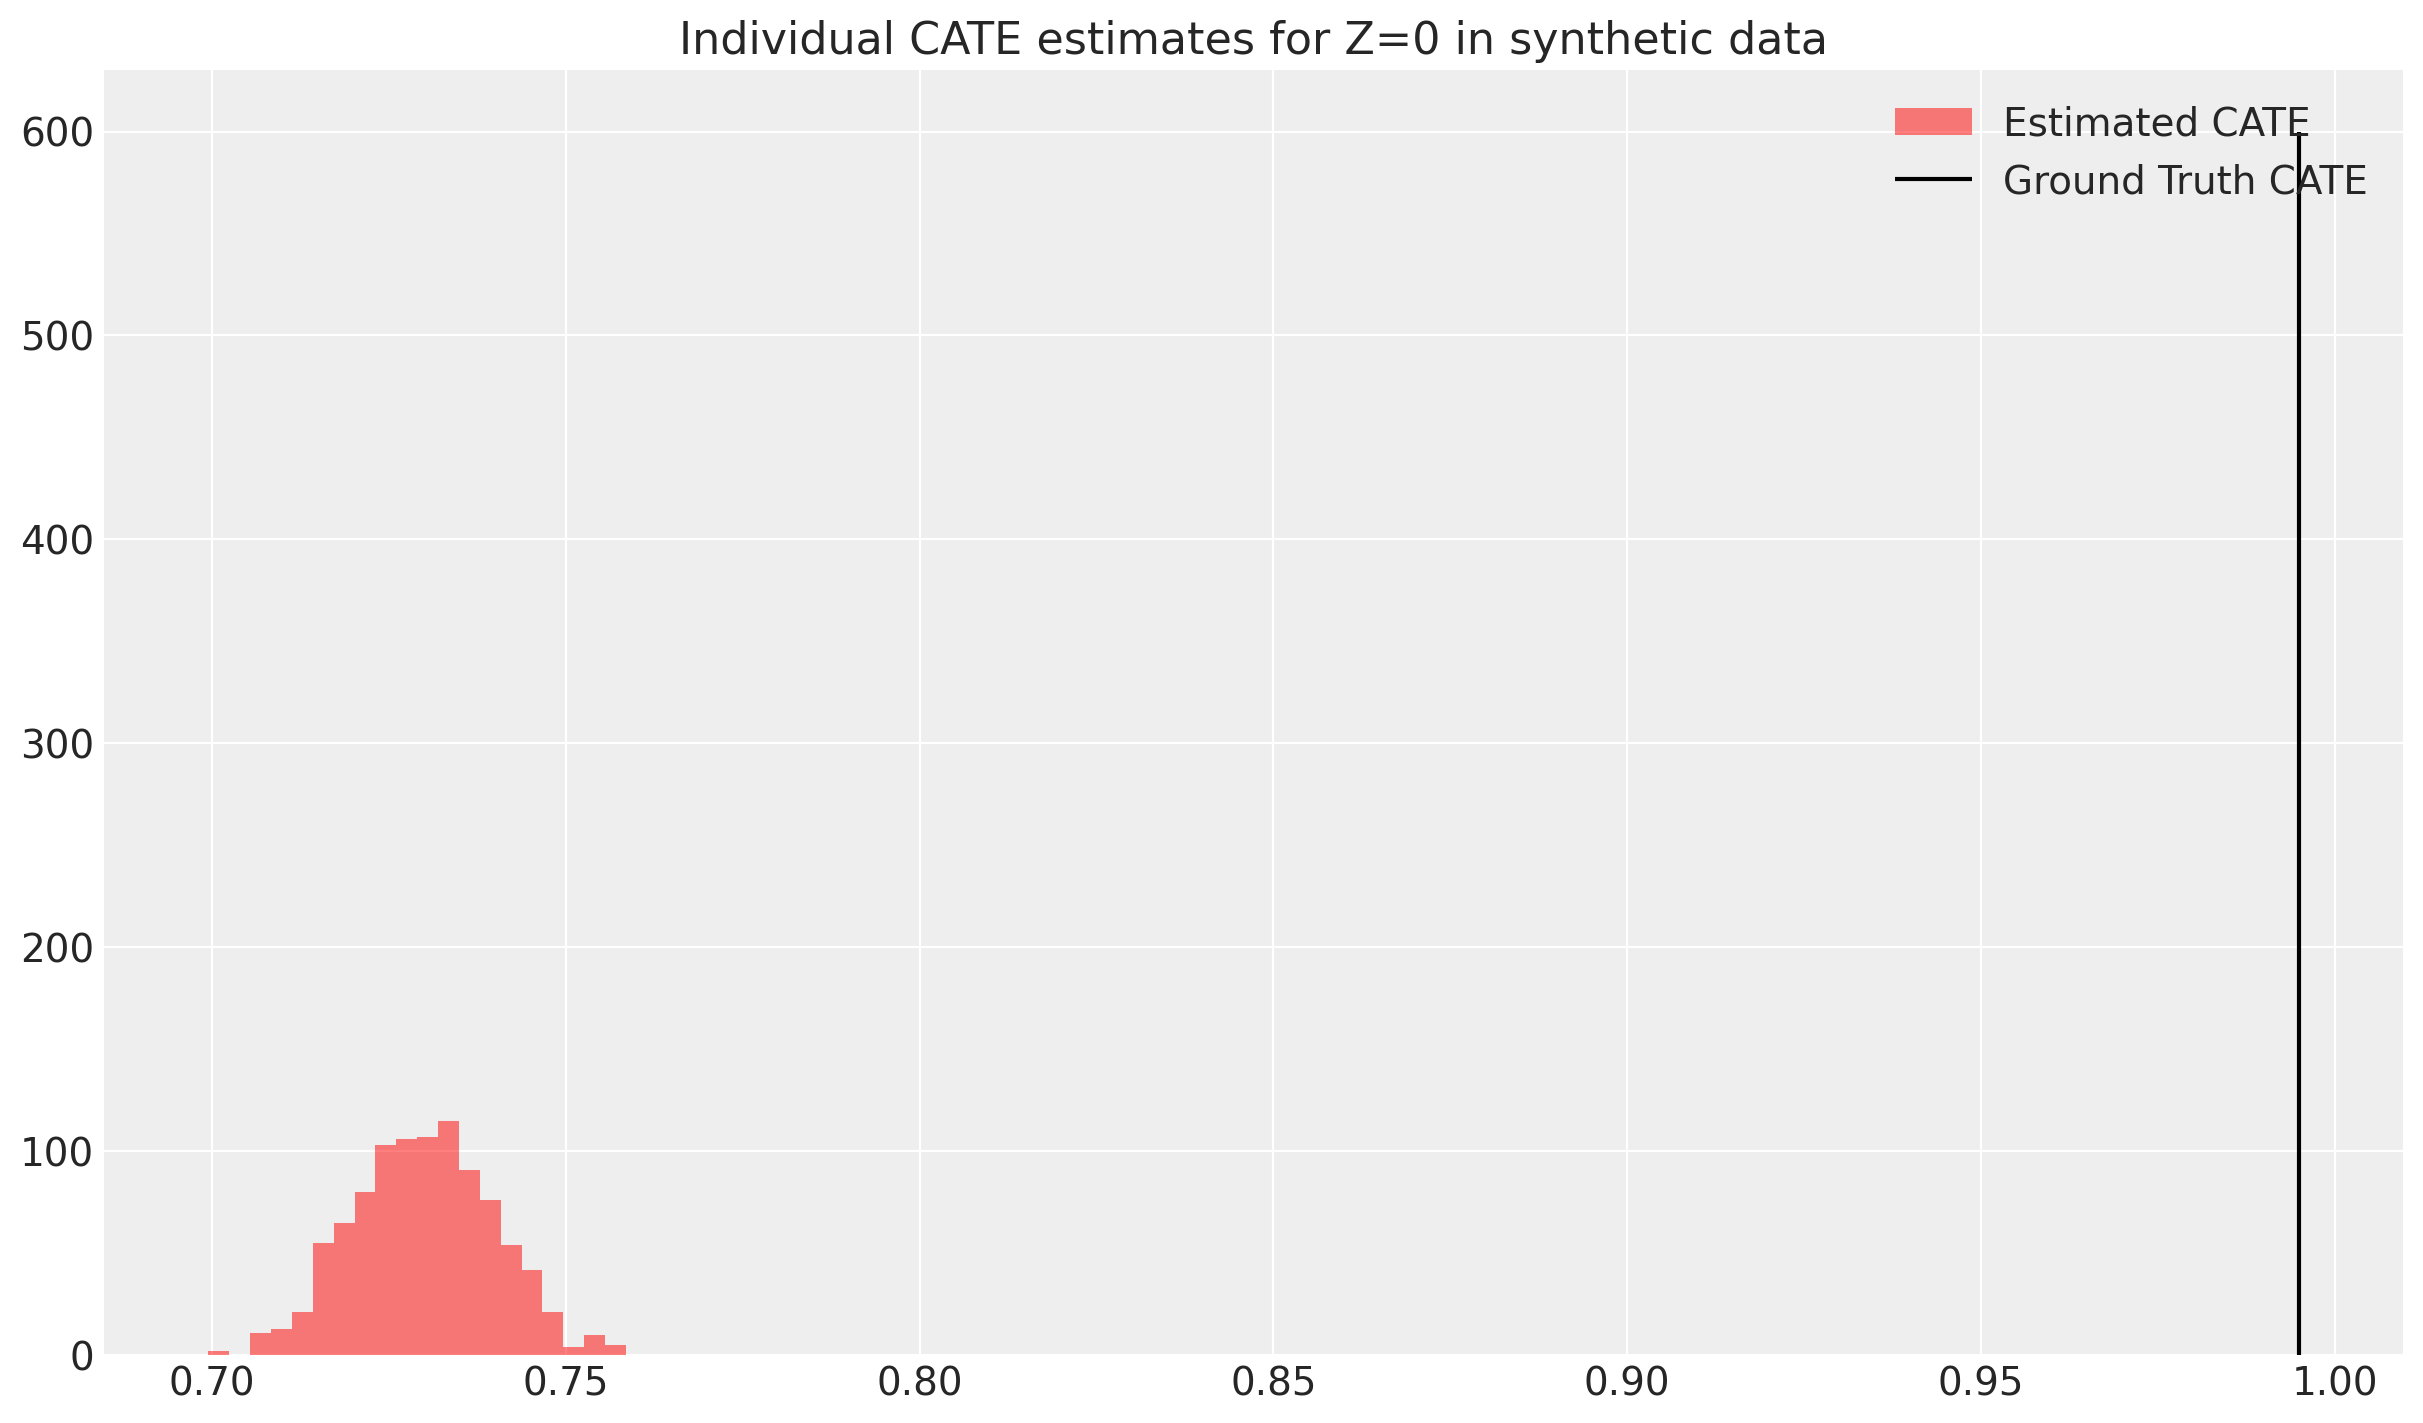

In [18]:
plt.hist(
    est_cates_z0,
    bins=20,
    color="red",
    label="Estimated CATE",
    alpha=0.5,
)
plt.vlines(
    true_cates_z0.mean().item(), 0, 600, color="black", label="Ground Truth CATE"
)
plt.title("Individual CATE estimates for Z=0 in synthetic data")
# plt.xlim(0.9, 1.05)
plt.legend()